In [2]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.utils import np_utils
import pickle
from keras.optimizers import Adam
import os
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import time
import tensorflow.compat.v1 as tf
from keras.utils.vis_utils import plot_model
#tf.disable_v2_behaviour()

#tf.compat.v1.
print(tf.version.GIT_VERSION, tf.version.VERSION)

v2.5.0-rc3-213-ga4dfb8d1a71 2.5.0


In [8]:
os.chdir(r'/home/jupyter/Combined Trajectory_Label_Geolife')
tf.Session(config=tf.ConfigProto(allow_soft_placement=True, log_device_placement=True))
sess = print(tf.Session(config=tf.ConfigProto(log_device_placement=True)))

start_time = time.clock()
np.random.seed(7)
random.seed(7)

filename = '../Combined Trajectory_Label_Geolife/Revised_InstanceCreation+NoJerkOutlier+Smoothing+GIS+WHOLE_COUNTRY.pickle'

with open(filename, mode='rb') as f:
    TotalInput, FinalLabel = pickle.load(f, encoding='latin1')  # Also can use the encoding 'iso-8859-1'

NoClass = len(list(set(np.ndarray.flatten(FinalLabel))))
Threshold = len(TotalInput[0, 0, :, 0])

# Making training and test data: 80% Training, 20% Test
Train_X, Test_X, Train_Y, Test_Y_ori = train_test_split(TotalInput, FinalLabel, test_size=0.20, random_state=7)

Train_Y = np_utils.to_categorical(Train_Y, num_classes=NoClass)
Test_Y = np_utils.to_categorical(Test_Y_ori, num_classes=NoClass)

# Model and Compile
model = Sequential()
activ = 'relu'
model.add(Conv2D(32, (1, 3), strides=(1, 1), padding='same', activation=activ, input_shape=(1, Threshold, 4)))
model.add(Conv2D(32, (1, 3), strides=(1, 1), padding='same', activation=activ))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(64, (1, 3), strides=(1, 1), padding='same', activation=activ))
model.add(Conv2D(64, (1, 3), strides=(1, 1), padding='same', activation=activ))
model.add(MaxPooling2D(pool_size=(1, 2)))

model.add(Conv2D(128, (1, 3), strides=(1, 1), padding='same', activation=activ))
model.add(Conv2D(128, (1, 3), strides=(1, 1), padding='same', activation=activ))
model.add(MaxPooling2D(pool_size=(1, 2)))
model.add(Dropout(.5))

model.add(Flatten())
A = model.output_shape
model.add(Dense(int(A[1] * 1/4.), activation=activ))
model.add(Dropout(.5))

model.add(Dense(NoClass, activation='softmax'))

optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

offline_history = model.fit(Train_X, Train_Y, epochs=62, batch_size=64, shuffle=False,
                            validation_data=(Test_X, Test_Y))
hist = offline_history

Device mapping: no known devices.
Device mapping: no known devices.


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  """


In [ ]:
# Saving the test and training score for varying number of epochs.
#with open('Revised_accuracy_history_largeEpoch_Smoothing.pickle', 'wb') as f:
#    pickle.dump([hist.epoch, hist.history['accuracy'], hist.history['val_accuracy']], f)

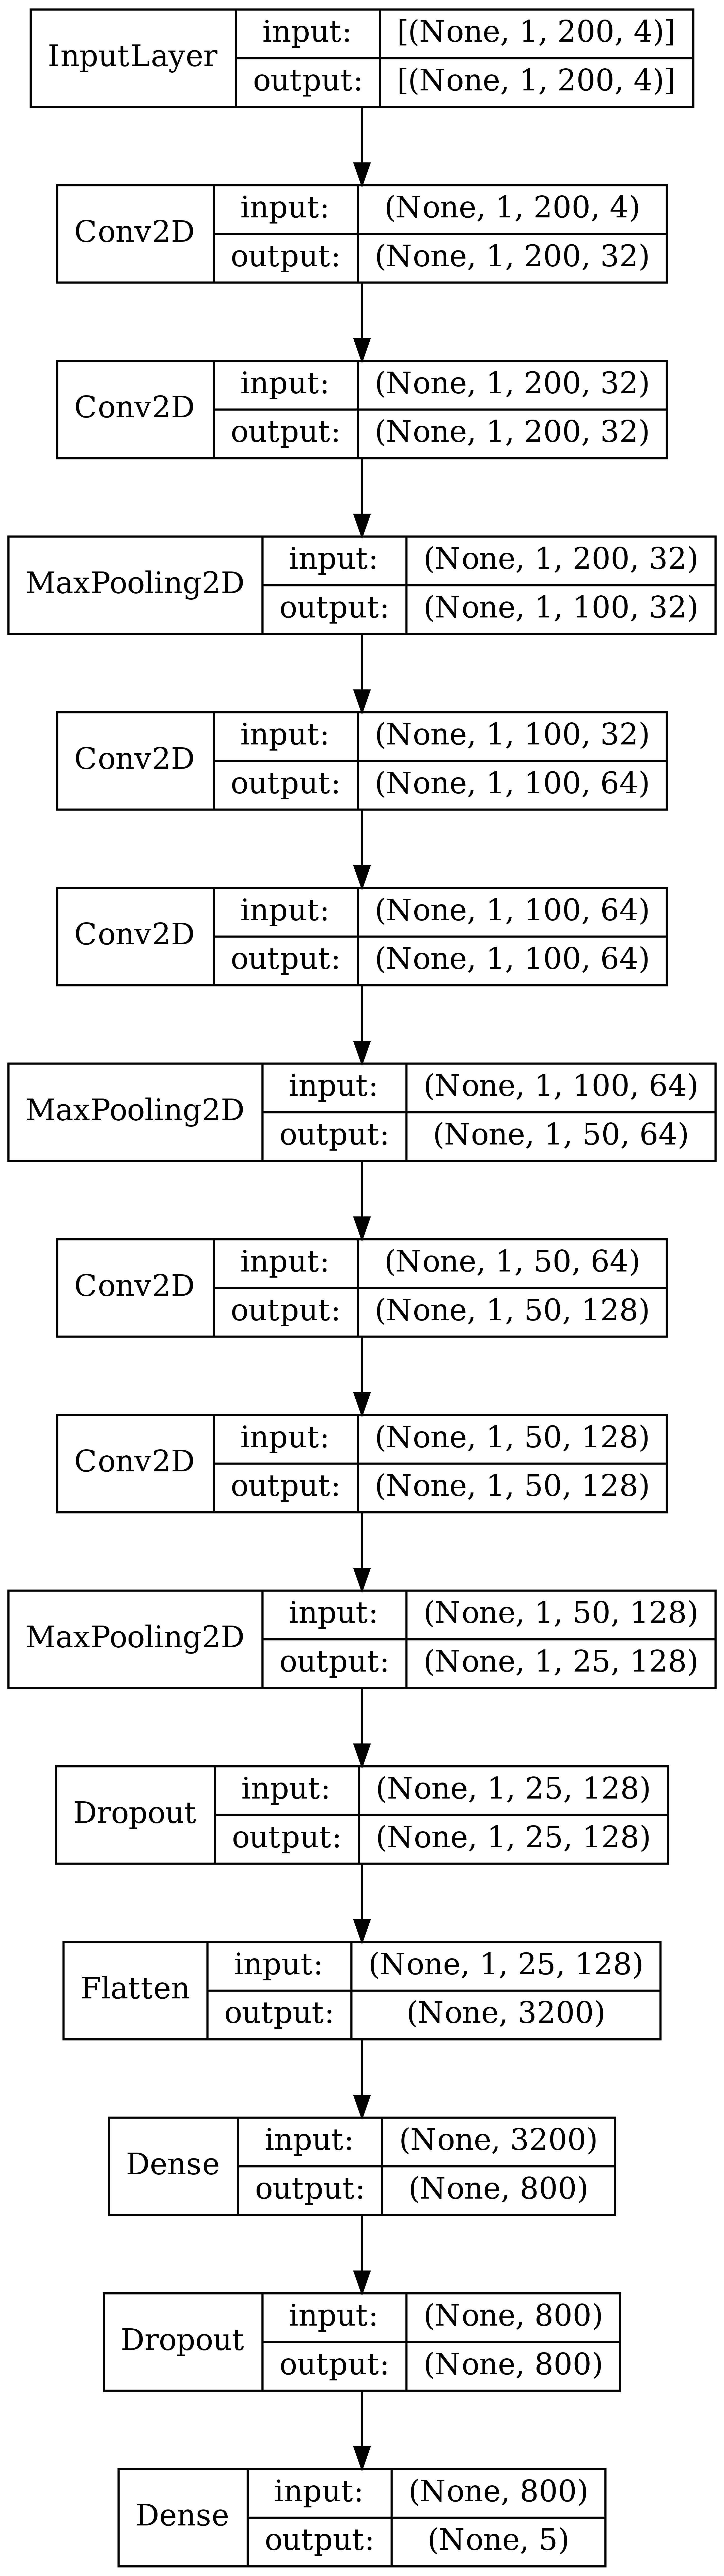

In [9]:
#Visualising the CNN architecture
plot_model(
    model,
    to_file="model.png",
    show_shapes=True,
    show_dtype=False,
    show_layer_names=False,
    rankdir="TB",
    expand_nested=False,
    dpi=600,)

In [3]:
A = np.argmax(hist.history['val_accuracy'])
print('the optimal epoch size: {}, the value of high accuracy {}'.format(hist.epoch[A], np.max(hist.history['val_accuracy'])))

# Calculating the test accuracy, precision, recall
Pred = model.predict(Test_X, batch_size=32)
Pred_Label = np.argmax(Pred, axis=1)

counter = 0
for i in range(len(Pred_Label)):
    if Pred_Label[i] == Test_Y_ori[i]:
        counter += 1
Accuracy = counter * 1./len(Pred_Label)

ActualPositive = []
for i in range(NoClass):
    AA = np.where(Test_Y_ori == i)[0]
    ActualPositive.append(AA)

PredictedPositive = []
for i in range(NoClass):
    AA = np.where(Pred_Label == i)[0]
    PredictedPositive.append(AA)

TruePositive = []
FalsePositive = []
for i in range(NoClass):
    AA = []
    BB = []
    for j in PredictedPositive[i]:
        if Pred_Label[j] == Test_Y_ori[j]:
            AA.append(j)
        else:
            BB.append(j)
    TruePositive.append(AA)
    FalsePositive.append(BB)
Precision = []
Recall = []
for i in range(NoClass):
    Precision.append(len(TruePositive[i]) * 1./len(PredictedPositive[i]))
    Recall.append(len(TruePositive[i]) * 1./len(ActualPositive[i]))

ConfusionM = confusion_matrix(list(Test_Y_ori), Pred_Label, labels=[0, 1, 2, 3, 4])

print('Confusion Matrix: ', ConfusionM)
print("Recall", Recall)
print('precision', Precision)
print(time.clock() - start_time, "seconds")

the optimal epoch size: 61, the value of high accuracy 0.764950692653656
Confusion Matrix:  [[1872   83   49    1  117]
 [ 209  857   42    8    5]
 [ 165   76 1038  111   49]
 [  86   38  221  437  106]
 [  98   10   21   30  759]]
Recall [0.882186616399623, 0.7644959857270295, 0.7213342599027102, 0.49211711711711714, 0.826797385620915]
precision [0.7703703703703704, 0.8054511278195489, 0.7571115973741794, 0.7444633730834753, 0.7326254826254827]
5667.258519 seconds


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:47: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
